In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [2]:
from keras.preprocessing import image, sequence
from keras.applications import VGG16
from keras.layers import Dense, Convolution2D, Dropout, LSTM, TimeDistributed, concatenate, Embedding, Bidirectional, Activation, RepeatVector, Merge
from keras.models import Sequential, Model
from keras.optimizers import Nadam

Using Theano backend.
Using cuDNN version 5110 on context None
Preallocating 10867/11439 Mb (0.950000) on cuda
Mapped name None to device cuda: Tesla K80 (0000:00:1E.0)


In [3]:
images_dir = os.listdir("./Flickr8k_Dataset/Flicker8k_Dataset/")

images_path = './Flickr8k_Dataset/Flicker8k_Dataset/'
captions_path = './Flickr8k_text/Flickr8k.token.txt'
train_path = './Flickr8k_text/Flickr_8k.trainImages.txt'
val_path = './Flickr8k_text/Flickr_8k.devImages.txt'

captions = open(captions_path, 'r').read().split("\n")
x_train = open(train_path, 'r').read().split("\n")
x_test = open(val_path, 'r').read().split("\n")

In [4]:
tokens = {}

for ix in range(len(captions)):
    temp = captions[ix].split("#")
    if temp[0] in tokens:
        tokens[temp[0]].append(temp[1][2:])
    else:
        tokens[temp[0]] = [temp[1][2:]]

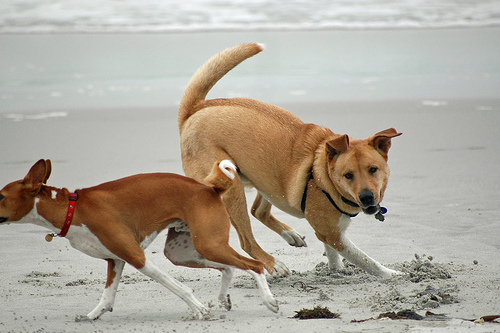

['Two different breeds of brown and white dogs play on the beach .', 'Two dogs are making a turn on a soft sand beach .', 'Two dogs playing in the sand at the beach .', 'Two dogs playing together on a beach .', 'Two large tan dogs play along a sandy beach .']


In [5]:
temp = captions[100].split("#")
from IPython.display import Image, display
z = Image(filename=images_path+temp[0])
display(z)

print tokens[temp[0]]

In [6]:
print "Number of Training Images {}".format(len(x_train))

Number of Training Images 6000


In [7]:
vgg = VGG16(weights='imagenet', include_top=True, input_shape=(224,224,3))

In [9]:
def preprocess_input(img):
    img = img[:, :, :, ::-1] #RGB to BGR
    img[:, :, :, 0] -= 103.939 
    img[:, :, :, 1] -= 116.779
    img[:, :, :, 2] -= 123.68
    return img

In [10]:
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    im = preprocess_input(im)
    return im

In [11]:
x = preprocessing(images_path+temp[0])
print x.shape

(1, 224, 224, 3)


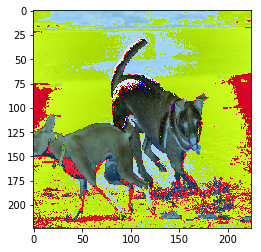

In [12]:
plt.figure(0)
plt.imshow(np.squeeze(x, axis=0))
plt.show()

In [ ]:
vgg.summary()

In [13]:
vgg = Model(inputs=vgg.input, outputs=vgg.layers[-2].output)

In [ ]:
vgg.summary()

# Encoding Images using VGG #

In [14]:
def get_encoding(model, img):
    image = preprocessing(images_path+img)
    pred = model.predict(image)
    pred = np.reshape(pred, pred.shape[1])
    return pred

In [15]:
train_dataset = open('./Flickr8k_text/fl_flickr_8k_train_dataset.txt','wb')
train_dataset.write("image_id\tcaptions\n")

val_dataset = open('Flickr8k_text/fl_flickr_8k_val_dataset.txt','wb')
val_dataset.write("image_id\tcaptions\n")

In [16]:
train_encoded_images = {}

c_train = 0
for img in x_train:
    train_encoded_images[img] = get_encoding(vgg, img)
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        train_dataset.write(img+"\t"+caption+"\n")
        train_dataset.flush()
        c_train += 1
train_dataset.close()

In [17]:
test_encoded_images = {}

c_test = 0
for img in x_test:
    test_encoded_images[img] = get_encoding(vgg, img)
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        val_dataset.write(img+"\t"+caption+"\n")
        val_dataset.flush()
        c_test += 1
val_dataset.close()

In [18]:
with open( "train_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(train_encoded_images, pickle_f )  
    
with open( "test_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(test_encoded_images, pickle_f )  

In [19]:
count = 0

for key,val in train_encoded_images.items():
    count += 1
    
print count
count = 0

for key,val in test_encoded_images.items():
    count += 1
    
print count

6000
1000


# Building Vocabulary #

In [7]:
pd_dataset = pd.read_csv("./Flickr8k_text/fl_flickr_8k_train_dataset.txt", delimiter='\t')
ds = pd_dataset.values
print ds.shape

(30000, 2)


In [8]:
sentences = []
for ix in range(ds.shape[0]):
    sentences.append(ds[ix, 1])
    
print len(sentences)

30000


In [9]:
words = [i.split() for i in sentences]

In [10]:
unique = []
for i in words:
    unique.extend(i)

In [11]:
print len(unique)

413377


In [12]:
unique = list(set(unique))
print len(unique)

vocab_size = len(unique)

8253


In [13]:
word_2_indices = {val:index for index, val in enumerate(unique)}
indices_2_word = {index:val for index, val in enumerate(unique)}

In [14]:
print word_2_indices['<start>']
print indices_2_word[4011]

4011
<start>


In [15]:
max_len = 0

for i in sentences:
    i = i.split()
    if len(i) > max_len:
        max_len = len(i)

print max_len

40


# Creating Padded Sequences and Next Words #

In [16]:
padded_sequences, subsequent_words = [], []

for ix in range(ds.shape[0]):
    partial_seqs = []
    next_words = []
    text = ds[ix, 1].split()
    text = [word_2_indices[i] for i in text]
    for i in range(1, len(text)):
        partial_seqs.append(text[:i])
        next_words.append(text[i])
    padded_partial_seqs = sequence.pad_sequences(partial_seqs, max_len, padding='post')

    next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=np.bool)
    
    #Vectorization
    for i,next_word in enumerate(next_words):
        next_words_1hot[i, next_word] = 1
        
    padded_sequences.append(padded_partial_seqs)
    subsequent_words.append(next_words_1hot)
    
padded_sequences = np.asarray(padded_sequences)
subsequent_words = np.asarray(subsequent_words)

print padded_sequences.shape
print subsequent_words.shape

(30000,)
(30000,)


In [17]:
with open('./train_encoded_images.p', 'rb') as f:
        encoded_images = pickle.load(f)

In [18]:
imgs = []

for ix in range(ds.shape[0]):
    imgs.append(encoded_images[ds[ix, 0]])

imgs = np.asarray(imgs)
print imgs.shape

(30000, 4096)


In [19]:
number_of_images = 1500 #12905

In [20]:
# captions = np.zeros([0, max_len])
# next_words = np.zeros([0, vocab_size])

# for ix in range(number_of_images):#img_to_padded_seqs.shape[0]):
#     captions = np.concatenate([captions, padded_sequences[ix]])
#     next_words = np.concatenate([next_words, subsequent_words[ix]])

# np.save("./captions_first15k_imgs_final.npy", captions)
# np.save("./next_words_first15k_imgs_final.npy", next_words)

captions = np.load("./captions_first15k_imgs_final.npy")
next_words = np.load("./next_words_first15k_imgs_final.npy")

print captions.shape
print next_words.shape

(19136, 40)
(19136, 8253)


In [21]:
images = []

for ix in range(number_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        images.append(imgs[ix])
        
images = np.asarray(images)

print images.shape

(19136, 4096)


In [22]:
image_names = []

for ix in range(number_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        image_names.append(ds[ix, 0])
        
print len(image_names)

19136


In [23]:
embedding_size = 128

In [24]:
image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(4096,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               524416    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 40, 128)           0         
Total params: 524,416
Trainable params: 524,416
Non-trainable params: 0
_________________________________________________________________


In [25]:
language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 128)           1056384   
_________________________________________________________________
lstm_1 (LSTM)                (None, 40, 256)           394240    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 40, 128)           32896     
Total params: 1,483,520
Trainable params: 1,483,520
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = Sequential()

model.add(Merge([image_model, language_model], mode='concat', concat_axis=-1))
model.add(Bidirectional(LSTM(1000, return_sequences=False)))
model.add(Dense(vocab_size))
model.add(Activation('softmax'))

model.load_weights("./final_weights_140epoch_50acc.h5")
model.compile(loss='categorical_crossentropy', optimizer=Nadam(), metrics=['accuracy'])
model.summary()

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_3 (Merge)              (None, 40, 256)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 2000)              10056000  
_________________________________________________________________
dense_5 (Dense)              (None, 8253)              16514253  
_________________________________________________________________
activation_3 (Activation)    (None, 8253)              0         
Total params: 28,578,189
Trainable params: 28,578,189
Non-trainable params: 0
_________________________________________________________________


In [58]:
from keras.callbacks import LearningRateScheduler
import keras.backend as K

In [ ]:
# def scheduler(epoch):
#     if epoch%2==0 and epoch!=0:
#         lr = K.get_value(model.optimizer.lr)
#         K.set_value(model.optimizer.lr, lr*.9)
#         print("lr changed to {}".format(lr*.9))
#     return K.get_value(model.optimizer.lr)

# lr_decay = LearningRateScheduler(scheduler)

model.fit([images, captions], next_words, batch_size=512, epochs=50)#, shuffle=False)

Epoch 1/50
19136/19136 [==============================] - 73s - loss: 3.9151 - acc: 0.1932    
Epoch 2/50
19136/19136 [==============================] - 73s - loss: 3.4279 - acc: 0.2291    
Epoch 3/50
19136/19136 [==============================] - 73s - loss: 3.1872 - acc: 0.2550    
Epoch 4/50
19136/19136 [==============================] - 73s - loss: 3.0098 - acc: 0.2737    
Epoch 5/50
19136/19136 [==============================] - 73s - loss: 2.8754 - acc: 0.2816    
Epoch 6/50
19136/19136 [==============================] - 73s - loss: 2.7562 - acc: 0.2919    
Epoch 7/50
19136/19136 [==============================] - 73s - loss: 2.7222 - acc: 0.2985    
Epoch 8/50
19136/19136 [==============================] - 73s - loss: 2.6362 - acc: 0.3025    
Epoch 9/50
19136/19136 [==============================] - 73s - loss: 2.6848 - acc: 0.2888    
Epoch 10/50
19136/19136 [==============================] - 73s - loss: 2.5309 - acc: 0.3104    
Epoch 11/50
19136/19136 [========================

In [28]:
model.save_weights("./final_weights_140epoch_50acc.h5")

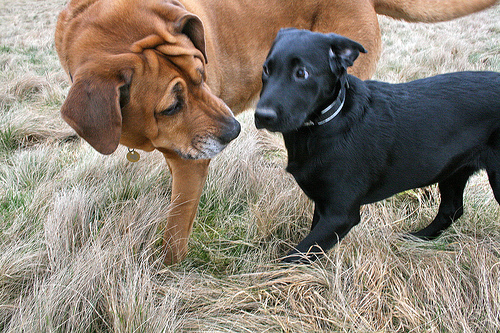

In [41]:
test_img = images[1200]

z = Image(filename=images_path+image_names[1200])
display(z)

In [42]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word_2_indices[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = image
        preds = model.predict([np.array([e]), np.array(par_caps)])
        word_pred = indices_2_word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

Argmax_Search = predict_captions(test_img)

In [43]:
def beam_search_predictions(image, beam_index = 3):
    start = [word_2_indices["<start>"]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            e = image
            preds = model.predict([np.array([e]), np.array(par_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [indices_2_word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption


Beam_Search_index_3 = beam_search_predictions(test_img, beam_index=3)
Beam_Search_index_5 = beam_search_predictions(test_img, beam_index=5)
Beam_Search_index_7 = beam_search_predictions(test_img, beam_index=7)

In [44]:
print "Agrmax Prediction : ",
print Argmax_Search
print "Beam Search Prediction with Index = 3 : ",
print Beam_Search_index_3
print "Beam Search Prediction with Index = 5 : ",
print Beam_Search_index_5
print "Beam Search Prediction with Index = 7 : ",
print Beam_Search_index_7

Agrmax Prediction :  A large brown dog looks at at dog in black dog in in in in black dog in in in in in in in in in in in in in in in in in in in in . .
Beam Search Prediction with Index = 3 :  A large brown dog looks at the dog .
Beam Search Prediction with Index = 5 :  A large brown dog looks at medium dog .
Beam Search Prediction with Index = 7 :  A large brown dog looks at medium dog .


In [46]:
tokens[image_names[1200]]

['A dog looks warily at the brown dog investigating his area .',
 'A large brown dog is looking at a medium sized black dog .',
 'A small black dog looks at a larger brown dog in a grassy field .',
 'The big brown dog looks at the small black dog in tall grass .',
 'There is a big dog looking at a little dog .']

In [45]:
print beam_search_predictions(test_img, beam_index=20)

A large brown dog looks at sized dog .


In [47]:
print beam_search_predictions(test_img, beam_index=1)

A large brown dog looks at at dog in black dog in in in in black dog in in in in in in in in in in in in in in in in in in in in . .
